## Experiment-0:  COCO

Training params: 
    - Batch size: 64
    - Image type: Background-masked images (RGB)
    - Background subtraction: False
    - Background subtraction value: 0.0
    - Image-size: 32 x 32
    - Optimizer: RMSProp
    - Initial LR: 0.01

In [1]:
import os
os.chdir("/nfs/students/winter-term-2020/project-4/yurtkulus/project-4")

%load_ext autoreload
%autoreload 2

In [2]:
from src.data.coco import COCODataModule
import torch
from src.models.pixelcnn import PixelCNN
from src.models.coco_pixelcnn import COCOPixelCNN
from src.experiments.experiment import Experiment
from src.utils.pixelcnn import generate_images
from src.utils.ood_test import plot_roc_auc

import torch.nn.functional as F
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np

"""
    In order to obtain foreground and background images from COCO dataset, 
    uncomment the lines below.
"""
# from src.data.oodcoco.oodcoco.oodcoco import run
# run()

'\n    In order to obtain foreground and background images from COCO dataset, \n    uncomment the lines below.\n'

In [3]:
print(os.cpu_count())
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
seed_everything(42)

20
cuda:0


42

In [4]:
cocodata_person = COCODataModule(batch_size=64,
                                 foreground_data_dir='./data/COCO/foreground_images/person', 
                                 background_data_dir='./data/COCO/background_images/person',
                                 normalize=True)
cocodata_person.prepare_data()
cocodata_person.setup()

# cocodata_car = COCODataModule(batch_size=8,
#                               foreground_data_dir='./data/COCO/foreground_images/car', 
#                               background_data_dir='./data/COCO/background_images/car', 
#                               convert_grayscale=True, 
#                               normalize=True)

# cocodata_dog = COCODataModule(batch_size=8,
#                               foreground_data_dir='./data/COCO/foreground_images/dog', 
#                               background_data_dir='./data/COCO/background_images/dog', 
#                               convert_grayscale=True, 
#                               normalize=True)

# cocodata_teddy_bear = COCODataModule(batch_size=8,
#                               foreground_data_dir='./data/COCO/foreground_images/teddy bear', 
#                               background_data_dir='./data/COCO/background_images/teddy bear/', 
#                               convert_grayscale=True, 
#                               normalize=True)

# cocodata_umbrella = COCODataModule(batch_size=8,
#                               foreground_data_dir='./data/COCO/foreground_images/umbrella', 
#                               background_data_dir='./data/COCO/background_images/umbrella', 
#                               convert_grayscale=True, 
#                               normalize=True)

# cocodata_clock = COCODataModule(batch_size=8,
#                               foreground_data_dir='./data/COCO/foreground_images/clock', 
#                               background_data_dir='./data/COCO/background_images/clock', 
#                               convert_grayscale=True, 
#                               normalize=True)


# experiment_name = 'PixelCNNBgSub_01_COCO_1'

experiment_name = 'PixelCNN_COCO_2_BG_Mask_RGB'

early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.0000,
   patience=10,
   verbose=True,
)

logger = TensorBoardLogger(
            'lightning_logs', name=experiment_name)

trainer = Trainer(max_epochs=50, gpus=1,logger=logger,  
                  callbacks=[early_stop_callback], auto_lr_find=True, num_sanity_val_steps=0)

EarlyStopping mode set to min for monitoring val_loss.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Set SLURM handle signals.

  | Name      | Type       | Params
-----------------------------------------
0 | blocks    | Sequential | 1 M   
1 | MaskAConv | Sequential | 38 K  
2 | MaskBConv | Sequential | 3 M   
3 | out       | Sequential | 1 M   


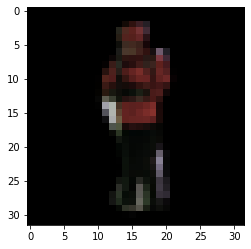

SystemExit: 0

/nfs/students/winter-term-2020/project-4/yurtkulus/anaconda3/envs/ml-lab/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3425: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [5]:
model = COCOPixelCNN(in_channel=3, masked_training=True)

trainer.fit(model, cocodata_person)

In [6]:
from pathlib import Path

path = Path('models/' + experiment_name)
# path.mkdir(parents=True, exist_ok=True)


# trainer.save_checkpoint(str(path) + '/' + experiment_name + '.ckpt')

In [7]:
model_path = str(path) + '/' + experiment_name + '.ckpt'
eval_model_bg_mask_RGB = COCOPixelCNN().load_from_checkpoint(checkpoint_path=model_path, 
                                                             in_channel=3, 
                                                             masked_training=True).cuda()
eval_model_bg_mask_RGB.eval()

# eval_model_bg_subtraction = COCOPixelCNN().load_from_checkpoint(checkpoint_path=model_path, 
#                                                                        background_subtraction=True, 
#                                                                        background_subtraction_value=0.1).cuda()

# eval_model = COCOPixelCNN().load_from_checkpoint(checkpoint_path=model_path, 
#                                                                        background_subtraction=False, 
#                                                                        background_subtraction_value=0.0).cuda()

# eval_model_bg_subtraction.eval()
# eval_model.eval()

COCOPixelCNN(
  (blocks): Sequential(
    (0): MaskedConv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): MaskedConv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (13): BatchNorm2d(64, e

ValueError: 'rgb' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

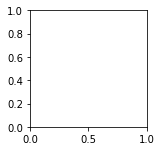

In [9]:
from src.utils.pixelcnn import generate_images_RGB, draw_likelihood_plot
# draw_likelihood_plot(cocodata_person.test_dataloader(), eval_model_full_img)
generate_images_RGB(eval_model_bg_mask_RGB)